# SimCADO imager simulation
This notebook is adapted from the example notebooks in SimCADO document: https://simcado.readthedocs.io/en/latest/user_docs/6_Examples_Tutorials.html

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from astropy.io import fits

import simcado
from simcado.source import *
from simcado import __data_dir__
print("SimCADO data directory is", __data_dir__)

import photutils

SimCADO data directory is /Users/spacegrey/opt/anaconda3/envs/simelt/lib/python3.9/site-packages/simcado/data


## Create source from fits file

In [7]:
# Import fits image
model = '../../RADMC3D/10jup50au/'
fname = 'npix1733lam214inc0.fits'
d = 100 # pc
layout = 'centre'
mode, micado_pixscale = 'zoom', 0.0015
#mode, micado_pixscale = 'wide', 0.004

with fits.open(model+fname) as inhdul:
    sourceimg = inhdul[0].data[0]
    sourcehdr = inhdul[0].header
try:
    print("Pixel unit:", sourcehdr['UNITS'])
except:
    print("Pixel unit:", sourcehdr['BUNIT'])

Pixel unit: Jy / pixel


size of the image: (1733, 1733)
range of the image: 0.0029709034497517905 and 0.0


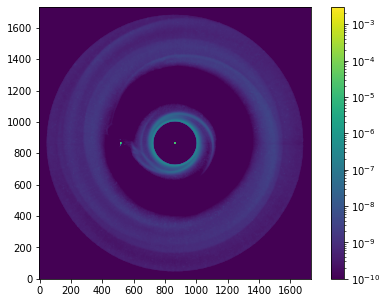

In [22]:
# Plot fits image
fig = plt.figure(figsize=(7,5))

cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))
plt.imshow(sourceimg, origin="lower", cmap=cmap, norm=LogNorm(vmin=1e-10))

plt.colorbar()
print("size of the image:", sourceimg.shape)
print("range of the image:", sourceimg.max(),"and", sourceimg.min())

In [23]:
a = len(sourceimg[0])
if (a % 2) == 0:
    sourceimg[int(a/2-1):int(a/2+1), int(a/2-1):int(a/2+1)] *= 0.01
else:
    sourceimg[int((a-1)/2),int((a-1)/2)] *= 0.01

In [5]:
# Check image pixel scale
try:
    pixscale = sourcehdr['CDELT1'] * -3600
except:
    pixscale = sourcehdr['CD1_1'] * -3600

# If image pixscale not the same as the detector pixscale, need to specify oversample to interpolate between the two scales. 
oversample = pixscale / micado_pixscale

print("Image pixel scale:", pixscale, "arcsec/pixel, oversample:", oversample)

Image pixel scale: 0.001442604398676696 arcsec/pixel, oversample: 0.9617362657844639


In [8]:
# Read spectrum (function from radmc3dpy)
def readSpectrum(fname):
    with open(fname, 'r') as rfile:
        # Read the format number
        dum = rfile.readline()
        # Read the number of wavelengths
        nwav = int(rfile.readline())
        # Read a blank line
        dum = rfile.readline()

        res = np.zeros([nwav, 2], dtype=np.float64)
        for iwav in range(nwav):
            dum = rfile.readline().split()
            res[iwav, 0] = float(dum[0])
            res[iwav, 1] = float(dum[1])
    return res

spectrum = readSpectrum(model+'sed0inc0_entire_sys.out')
wav = spectrum[:,0]
spec = spectrum[:,1] * 1e23 / d ** 2      # Conversion from erg s-1 cm-2 Hz-1 to Jy at d pc

Simcado takes spectrum input with unit photons/(m2 s bin). Compute $f_{\lambda}$, the number of ph/(m2 s um) that correspond to 1 Jy at $\lambda_{\mathrm{ref}}$, and the input $flux$\[ph/(m2 s bin)\] = $spec$\[Jy\] $\times \ \ f_{\lambda}$\[ph/(m2 s um)/Jy\] $\times \ \ dlam$\[um/bin\] 

In [10]:
# Convert flux level (adapted from SIMMetis example notebook)
from astropy import units as u
lam_ref = 2.14 * u.um
flam_ref = (1 * u.Jy).to(u.ph * u.s**-1 * u.m**-2 * u.um**-1, 
                        equivalencies=u.spectral_density(lam_ref))
print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, flam_ref))

dlam = np.zeros(len(wav)-1)  # [um], spectral bin width
for i in range(len(wav)-1):
    dlam[i] = wav[i+1] - wav[i]
flux = spec[:-1] * flam_ref.value * dlam
lams = wav[:-1]

1 Jy at  2.14 um corresponds to 7052290.56 ph / (m2 s um)


In [24]:
# Creating the source
src_disk = source_from_image(sourceimg, lams, flux, # spectra in [ph/s/m2/bin]
                                    plate_scale=pixscale, # The plate scale of the simulated image
                                    oversample=oversample) 


In [773]:
'''
my_cmds = simcado.UserCommands()
#my_cmds["OBS_SEEING"] = 0.01   # FWHM in arcsec
my_cmds["SCOPE_PSF_FILE"] = 'scao'
my_cmds["SCOPE_AO_EFFECTIVENESS"] = 50 # this command has no effect
my_cmds["FPA_CHIP_LAYOUT"] = "small"
my_cmds["SIM_DETECTOR_PIX_SCALE"] = 0.0015
my_cmds["SCOPE_STREHL_RATIO"] = 0.5 # this has no effect too
#my_cmds["SCOPE_JITTER_FWHM"] = 0.01
print(my_cmds.cmds)

SCOPE_PSF_FILE          scao                    # [scao (default), <filename>, ltao, mcao, poppy] import a PSF from a file.
SCOPE_STREHL_RATIO      1                       # [0..1] defines the strength of the seeing halo if SCOPE_PSF_FILE is "default"
SCOPE_AO_EFFECTIVENESS  100                     # [%] percentage of seeing PSF corrected by AO - 100% = diff limited, 0% = 0.8" seeing
SCOPE_JITTER_FWHM       0.001                   # [arcsec] gaussian telescope jitter (wind, tracking)
'''

'\nmy_cmds = simcado.UserCommands()\n#my_cmds["OBS_SEEING"] = 0.01   # FWHM in arcsec\nmy_cmds["SCOPE_PSF_FILE"] = \'scao\'\nmy_cmds["SCOPE_AO_EFFECTIVENESS"] = 50\nmy_cmds["FPA_CHIP_LAYOUT"] = "small"\nmy_cmds["SIM_DETECTOR_PIX_SCALE"] = 0.0015\nmy_cmds["SCOPE_STREHL_RATIO"] = 0.5\n#my_cmds["SCOPE_JITTER_FWHM"] = 0.01\nprint(my_cmds.cmds)\n'

In [35]:
# Runing the simulation with two hours of exposure time
lam_min = 0.78
lam_max = 2.5
sim_image = simcado.run(src_disk, mode=mode, detector_layout=layout, filter_name='Ks', OBS_NDIT=1, OBS_DIT=3600, 
                        SIM_LAM_MIN=lam_min, SIM_LAM_MAX=lam_max, SCOPE_JITTER_FWHM=0.08)
sim_image2 = simcado.run(src_disk, mode=mode, detector_layout=layout, filter_name='Ks', OBS_NDIT=1, OBS_DIT=3600, 
                        SIM_LAM_MIN=lam_min, SIM_LAM_MAX=lam_max)

Detector layout
 id x_cen y_cen  xhw   yhw  x_len y_len pixsize angle gain
--- ----- ----- ----- ----- ----- ----- ------- ----- ----
  5   0.0   0.0 30.72 30.72  4096  4096   0.015   0.0  1.0
Creating 8 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 5
Reading out chip 5 using superfast
DIT = 3600    NDIT = 1
Detector layout
 id x_cen y_cen  xhw   yhw  x_len y_len pixsize angle gain
--- ----- ----- ----- ----- ----- ----- ------- ----- ----
  5   0.0   0.0 30.72 30.72  4096  4096   0.015   0.0  1.0
Creating 8 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 5
Reading out chip 5 using superfast
DIT = 3600    NDIT = 1


Text(0.5, 1.0, 'OBS_DIT=3600')

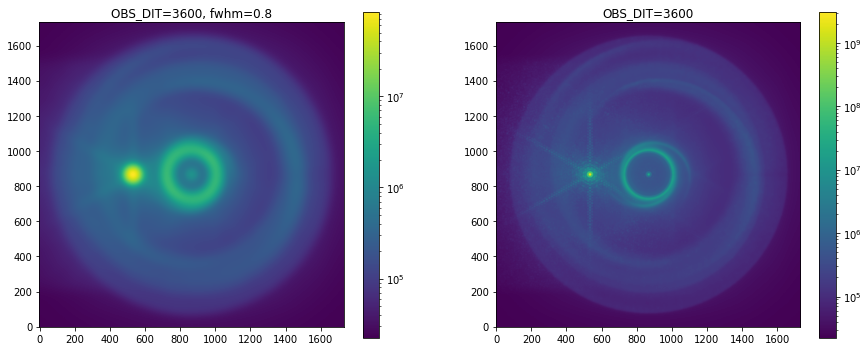

In [37]:
#extent = (xmin, xmax, ymin, ymax) = (400, 624, 400, 624)      # small, zoom
#extent = (xmin, xmax, ymin, ymax) = (100, 924, 100, 924)
#extent = (xmin, xmax, ymin, ymax) = (1600, 2496, 1600, 2496)  # centre, wide
extent = (xmin, xmax, ymin, ymax) = (1000, 3096, 1000, 3096)  # centre, zoom

size = sim_image[0].data.shape[0]
cen = int(size/2)
r = int(1733/2)
if cen-r > 0:
    sim_image[0].data = sim_image[0].data[cen-r:cen+r,cen-r:cen+r]
    sim_image2[0].data = sim_image2[0].data[cen-r:cen+r,cen-r:cen+r]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1=ax1.imshow(sim_image[0].data, norm=LogNorm(),origin="lower")
#im1=ax1.imshow(sim_image_2h[0].data, norm=LogNorm(),origin="lower")
im2=ax2.imshow(sim_image2[0].data, norm=LogNorm(), origin='lower')
fig.colorbar(im1, ax=ax1)
ax1.set_title("OBS_DIT=3600, fwhm=0.08")
fig.colorbar(im2, ax=ax2)
ax2.set_title("OBS_DIT=3600")

In [93]:
sim_image_2h.writeto(model+'MICADO_2h.fits', overwrite=True)

## Additional checks

(173, 173)

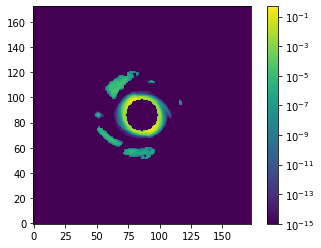

In [394]:
# Check oversampled image
oversample = 1
import scipy.ndimage.interpolation as spi
newimg = spi.zoom(image, oversample, order=3)
plt.imshow(newimg, origin="lower", cmap=cmap, norm=LogNorm(vmin=1e-15))
plt.colorbar()
newimg.shape

['K-short', 'xH2', 'R', 'J-short', 'xH1', 'K-cont', 'Ks', 'Ks2', 'U', 'B', 'xI1', 'V', 'H-long', 'I-long', 'xI2', 'Spec_HK', 'xJ2', 'Y', 'Br-gamma', 'He-I', 'xJ1', 'xK1', 'J', 'xK2', 'H', 'Spec_IJ', 'K-mid', 'I', 'xY1', 'K-long', 'J-long', 'H2_1-0S1', 'xY2', 'H-short', 'Pa-beta', 'H-cont', 'FeII']


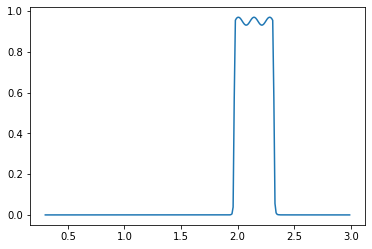

In [261]:
# View filter
print(simcado.optics.get_filter_set())
T_curve = simcado.optics.get_filter_curve('Ks2')
T_curve.plot()